# JPX Tokyo Stock Exchange Prediction

## Data and problem definition

This is a Kaggle competition. The first one we decided to work on as a team in VO2. It is a past competition so the only purpose is to learn and be prepared for the next competition.

Here is the link to the competition -> https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/overview.

The dataset can be found here: https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/data.

The objective of the competition is to use the given market data to rank the stocks eligible for predictions (around 2,000 stocks) from highest to lowest expected returns and the prediction is evaluated on the difference in returns between the top and bottom 200 stocks

Files:

stock_prices.csv -> The core file of interest. Includes the daily closing price for each stock and the target column.

options.csv -> Data on the status of a variety of options based on the broader market. Many options include implicit predictions of the future price of the stock market and so may be of interest even though the options are not scored directly.

secondary_stock_prices.csv -> The core dataset contains on the 2,000 most commonly traded equities but many less liquid securities are also traded on the Tokyo market. This file contains data for those securities, which aren't scored but may be of interest for assessing the market as a whole.

trades.csv -> Aggregated summary of trading volumes from the previous business week.

financials.csv -> Results from quarterly earnings reports.

stock_list.csv -> Mapping between the SecuritiesCode and company names, plus general information about which industry the company is in.

## Evaluation

Submissions are evaluated on the Sharpe Ratio of the daily spread returns. You will need to rank each stock active on a given day. The returns for a single day treat the 200 highest (e.g. 0 to 199) ranked stocks as purchased and the lowest (e.g. 1999 to 1800) ranked 200 stocks as shorted. The stocks are then weighted based on their ranks and the total returns for the portfolio are calculated assuming the stocks were purchased the next day and sold the day after that.

In [97]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

## Exploratory Data Analysis

We start by analysing the main dataset, the one with data for 2000 stocks. 

Here are the main observation we obtain from this analysis:

- The column `RowID` doesn't seem to be useful, as it adds no new information. It is just the date followed by the stock id, in String format, but we can get that information from the columns `Date` and `SecurityCode`.

- The column `Date` is a date, so we should use the option `parse_dates=["Date"]` when reading the csv to get that column in datetime format.

- Price columns (`High`, `Low`, `Open` and `Close`) are missing 7608 values. We should investivate what do these values correspond to. Observe that there is no missing values in the column `Volume`, but this is because on non tradable days volume is 0 although the 4 price columns should be NaN (we checked that the column `Volume` has 7608 time the value 0.).

In [98]:
df = pd.read_csv('/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv', low_memory=False)
df.head(5).T

,0,1,2,3,4
RowId,20170104_1301,20170104_1332,20170104_1333,20170104_1376,20170104_1377
Date,2017-01-04,2017-01-04,2017-01-04,2017-01-04,2017-01-04
SecuritiesCode,1301,1332,1333,1376,1377
Open,2734.0,568.0,3150.0,1510.0,3270.0
High,2755.0,576.0,3210.0,1550.0,3350.0
Low,2730.0,563.0,3140.0,1510.0,3270.0
Close,2742.0,571.0,3210.0,1550.0,3330.0
Volume,31400,2798500,270800,11300,150800
AdjustmentFactor,1.0,1.0,1.0,1.0,1.0
ExpectedDividend,NaN,NaN,NaN,NaN,NaN


The next line will give us the number of nan values for each column.

In [99]:
df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [100]:
Codes=df['SecuritiesCode'].unique()
print(len(Codes))

2000


In [101]:
testdf=df

In [102]:
testdf

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [103]:
emptydiv=testdf[testdf['ExpectedDividend'].isnull()]
nonempty=testdf[testdf['ExpectedDividend'].notnull()]

In [104]:
emptydiv=emptydiv.assign(ExpectedDividend=0.0)

In [105]:
testdf = pd.concat([emptydiv,nonempty],axis=0)

In [106]:
testdf = testdf.sort_index()

In [107]:
testdf.isna().sum()

RowId                  0
Date                   0
SecuritiesCode         0
Open                7608
High                7608
Low                 7608
Close               7608
Volume                 0
AdjustmentFactor       0
ExpectedDividend       0
SupervisionFlag        0
Target               238
dtype: int64

The next line shows that the column `Volume` contains the same number of 0's as the number of missing values in the column `Close`. 

In [108]:
df[df['Volume']==0].shape

(7608, 12)

In [109]:
df[df['Volume']==0]['Target'].isnull().sum()

238

Every NaN value of 'Target' is included in the rows in which the traded volume is 0.

Not applying the Adjustment factors would make us work with "discontinuous" time series, we can see for example what happens with instrument 9470 

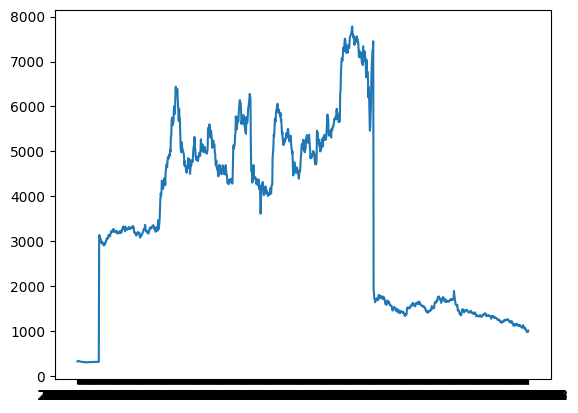

In [110]:
df_9470 = df[df['SecuritiesCode'] == 9470].sort_values(by = 'Date')
df_9470["Adj Close"] = df_9470["Close"] * df_9470["AdjustmentFactor"]
plt.plot(df_9470["Date"], df_9470["Close"])

## Data Import and Transformation

What to do with empty rows ? ExpectedDividend's NaN can be replaced by O's. When the traded volume of the day is 0 ; Open, High, Low and Close are empty. Every NaN value of 'Target' is included in those rows. Should we just drop them ? Is there a better way to fill at least Open, High, Low and Close and then only drop 238 rows ?

Use secondary_stock_prices.csv and/or options.csv to train the model ?

Can we use the other csv files ?

Drop date/securitiescode/rowid ?


### Different ideas for data augmentation (not everything needs to be implemented) :

https://arxiv.org/pdf/2206.13508.pdf

https://arxiv.org/pdf/1902.10755.pdf


- Stock^X, X!=0
- f(Stock) with f non-linear
- 2*Max(Stock)-Stock
- 2*(Max(Stock)-Stock)
- X*Stock, X>0
- Integral(Stock) from t=-X to t=0, X>0
- Noise introduction (Gaussian error term)
- Flipping
- Time translation
- Permutation of series slices
- Stretch/Compress time-wise
- Fourier transform


In [114]:
from sklearn.preprocessing import MinMaxScaler

# Load the data
#df = pd.read_csv("financial_data.csv")

# Normalize the data
scaler = MinMaxScaler()
testdf['Close'] = scaler.fit_transform(testdf[['Close']])

# Define the data
X = testdf.drop(['Target'],axis=1)
y = testdf.loc[:,'Target']
# Split the data into training and testing sets
X_train, y_train = X[:int(0.8*len(X))], y[:int(0.8*len(y))]
X_test, y_test = X[int(0.8*len(X)):], y[int(0.8*len(y)):]

### Use generators instead of the entire dataframe at once.

## Baseline Model

We create a barebones model (tensorflow) that we will try to improve over time. It is a simple as it gets.

Some ideas to improve on the model :

- https://paperswithcode.com/paper/self-distillation-for-gaussian-process
- https://paperswithcode.com/paper/delay-sde-net-a-deep-learning-approach-for
- https://paperswithcode.com/paper/variational-operator-learning-a-unified
- https://paperswithcode.com/paper/enhancing-safe-exploration-using-safety-state
- Model focused Curriculum Learning
- Attention Mechanism
- More layers (Dropout, Conv, ...)

In [118]:
import tensorflow as tf

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

## Model Training and Evaluation

Metric : MSE (Mean Squared Error)

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)

# Make predictions
predictions = model.predict(X_test)

# Plot the predictions
import matplotlib.pyplot as plt
plt.plot(y_test)
plt.plot(predictions)
plt.legend(["Actual", "Predicted"])
plt.show()